In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_40DLorenz.recursive_Markovian_PostMeanScore_40DLorenz_Chaos_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
num_paths = 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
config = get_config()

In [3]:
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/40DLnzChaosGPU/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
config = get_config()
true_files, local_files, bws = get_drift_files(config=config, root_dir=root_dir)
len(local_files)

20

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_53380/4007976572.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_53380/4007976572.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


14.339733932967132 0.0073079 inf


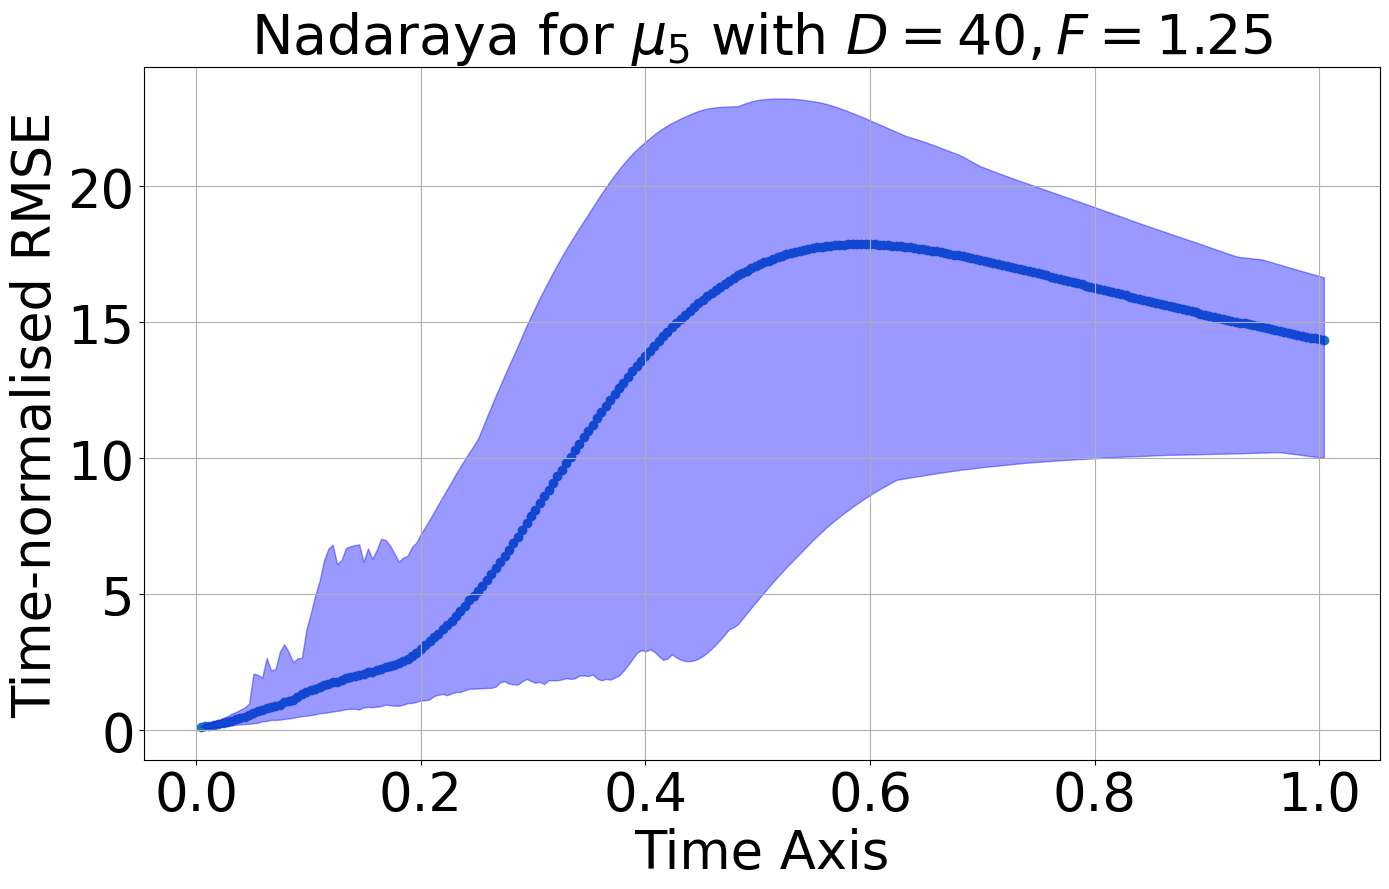

Final time cumulative MSE local-time error 14.339733932967132 with IQR ((10.015282485968365, 16.65161408681048))at bw 0.0073079 for 1.25FConst

12.052449837367526 0.009649 14.339733932967132


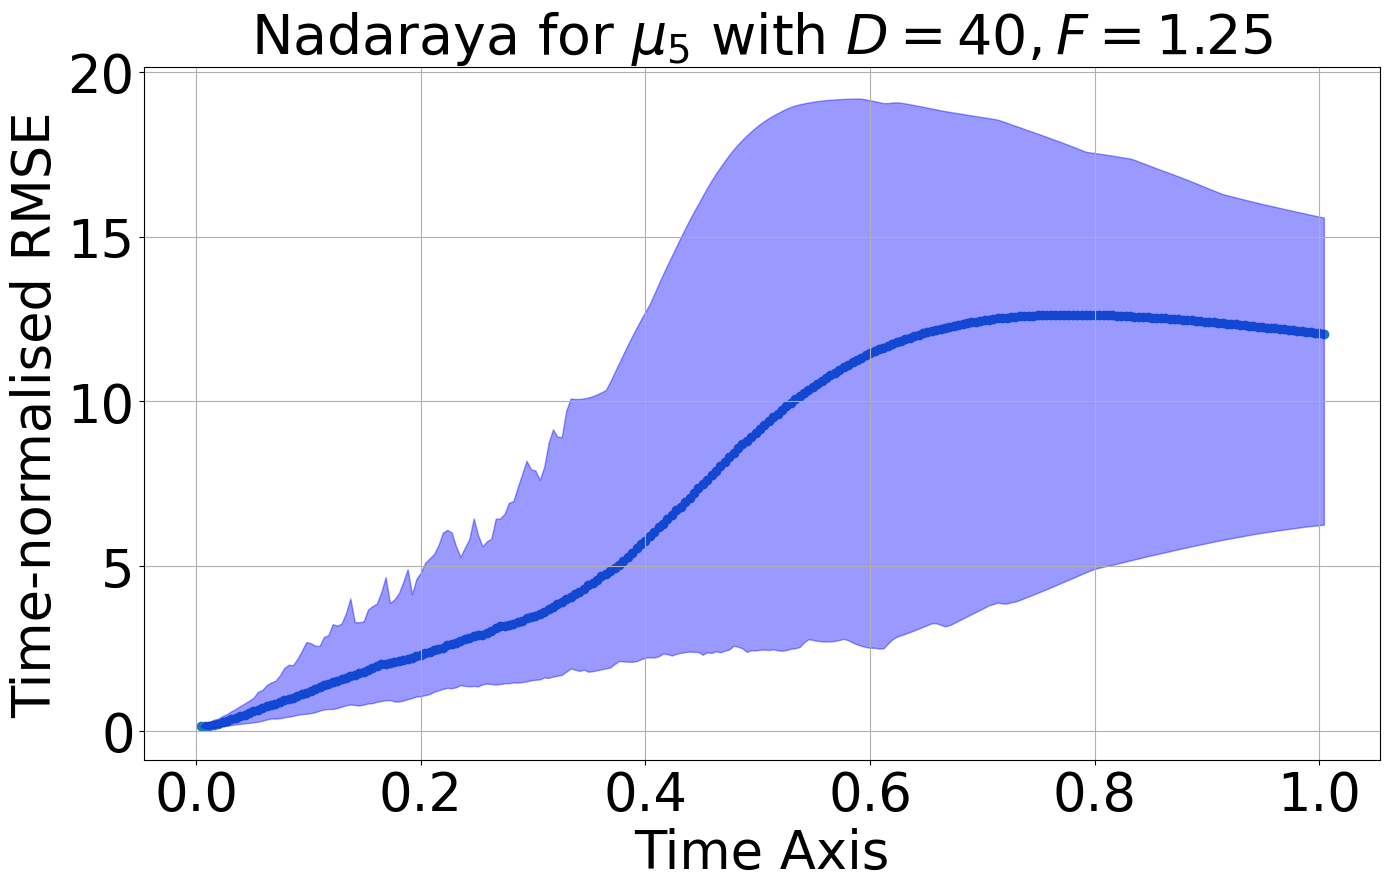

Final time cumulative MSE local-time error 12.052449837367526 with IQR ((6.254083907560917, 15.57641176303445))at bw 0.009649 for 1.25FConst

8.284823626115008 0.0127401 12.052449837367526


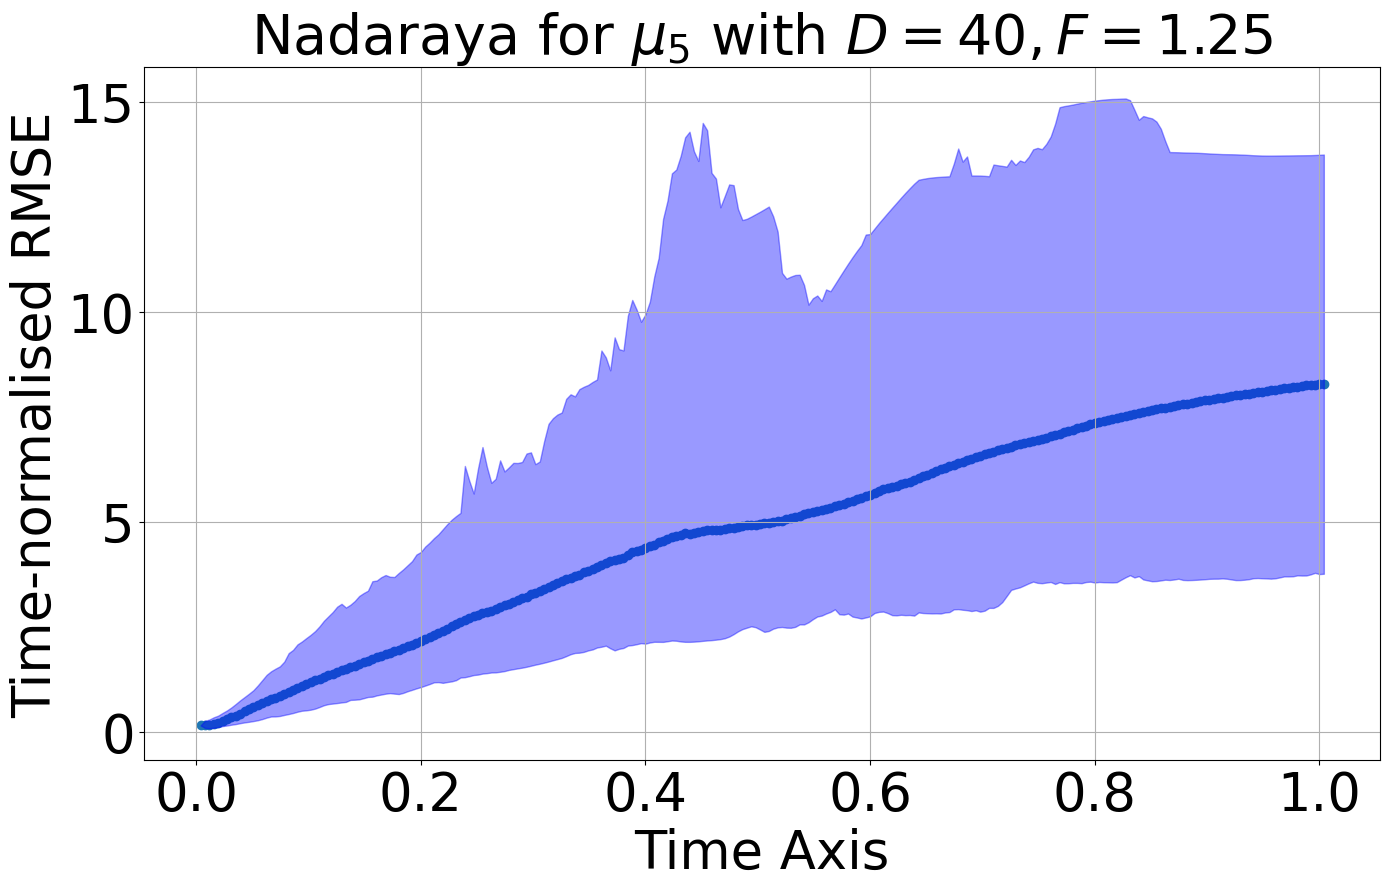

Final time cumulative MSE local-time error 8.284823626115008 with IQR ((3.7616975352140405, 13.740971073759175))at bw 0.0127401 for 1.25FConst

6.556098172751565 0.0168214 8.284823626115008


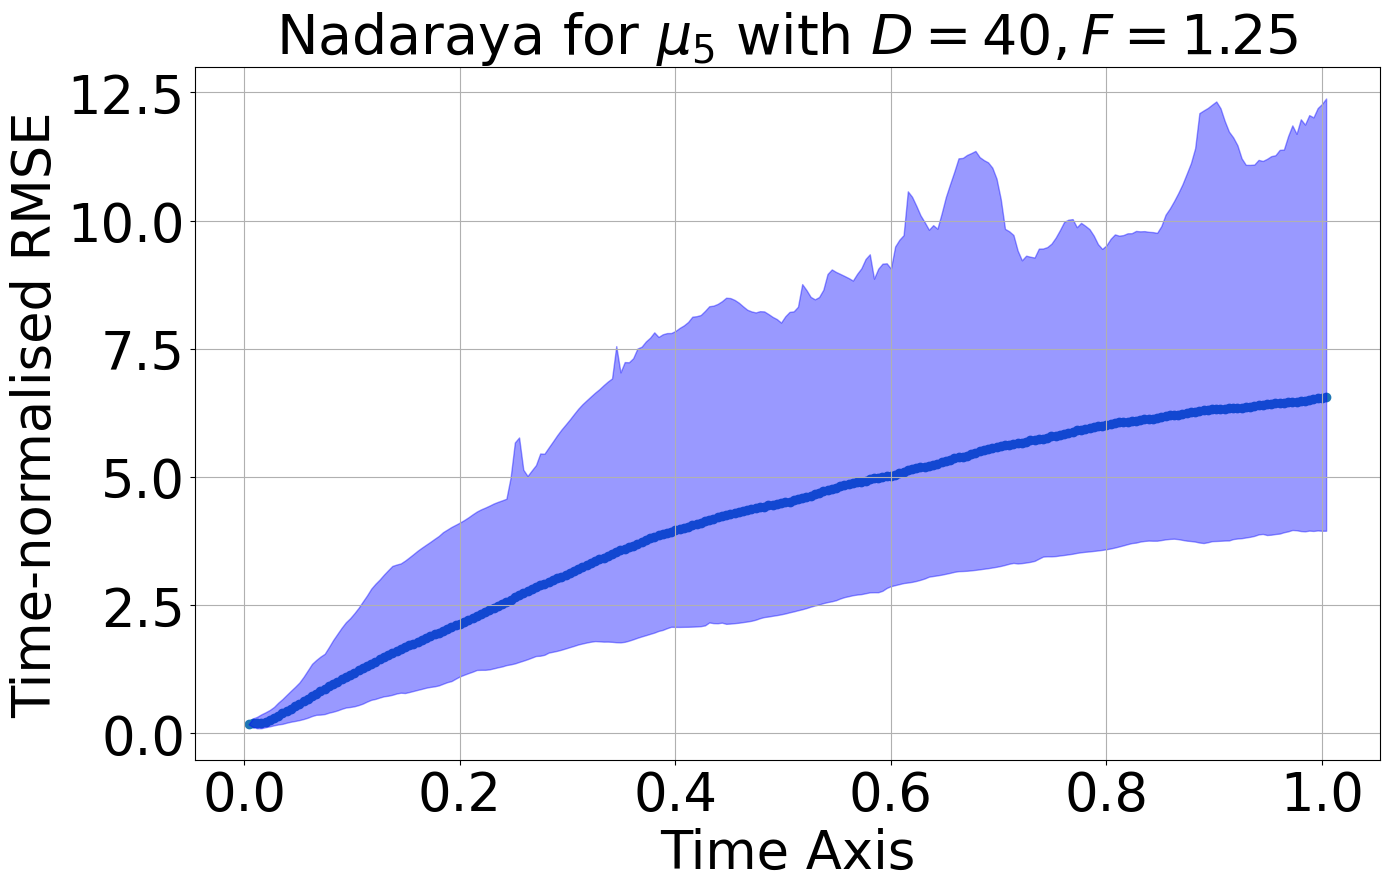

Final time cumulative MSE local-time error 6.556098172751565 with IQR ((3.949274083219948, 12.382409950247542))at bw 0.0168214 for 1.25FConst

6.226985514994984 0.0222102 6.556098172751565


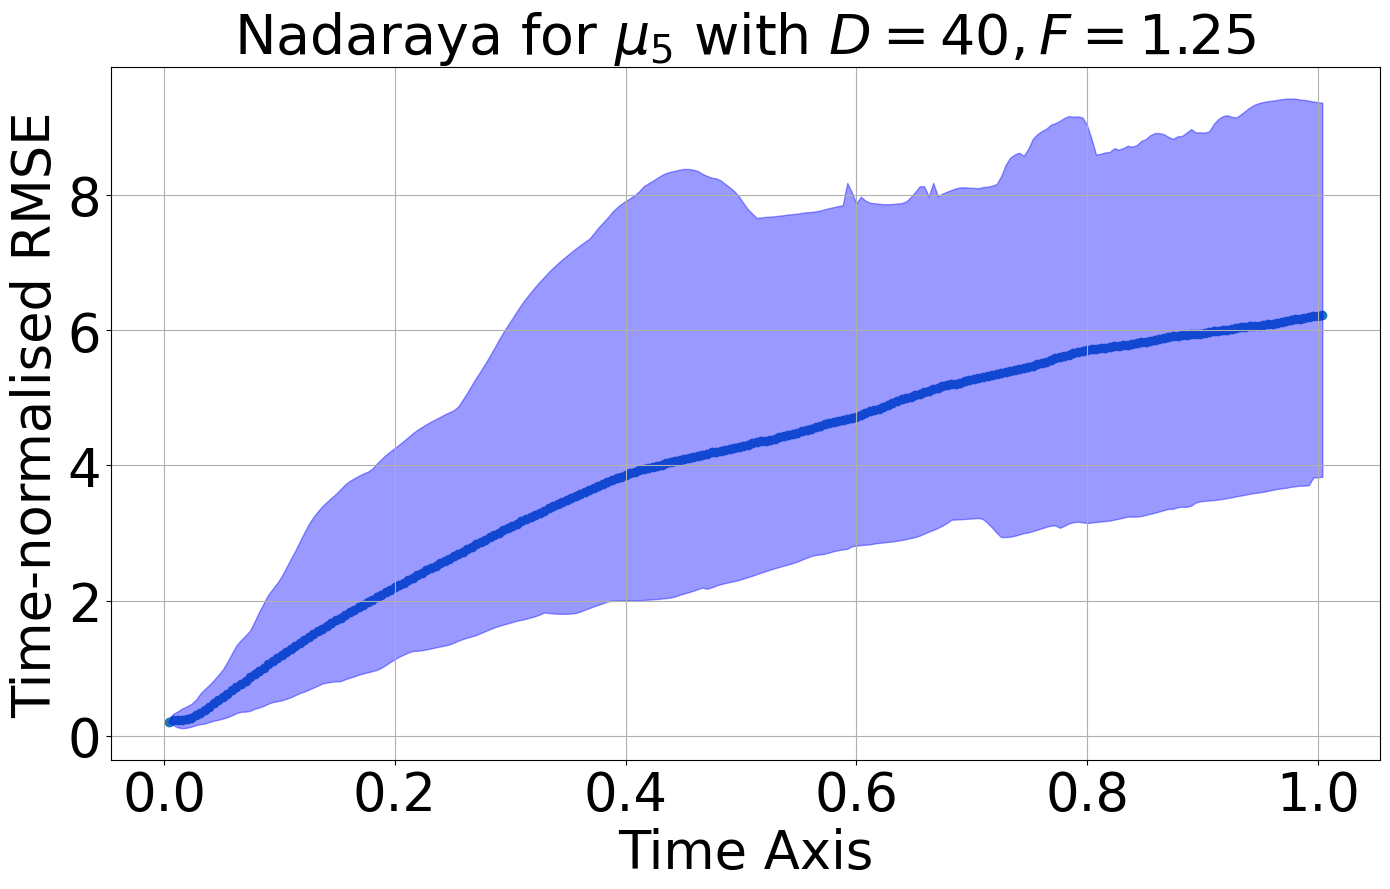

Final time cumulative MSE local-time error 6.226985514994984 with IQR ((3.830485724241065, 9.363183003510398))at bw 0.0222102 for 1.25FConst

6.067784109180492 0.0293252 6.226985514994984


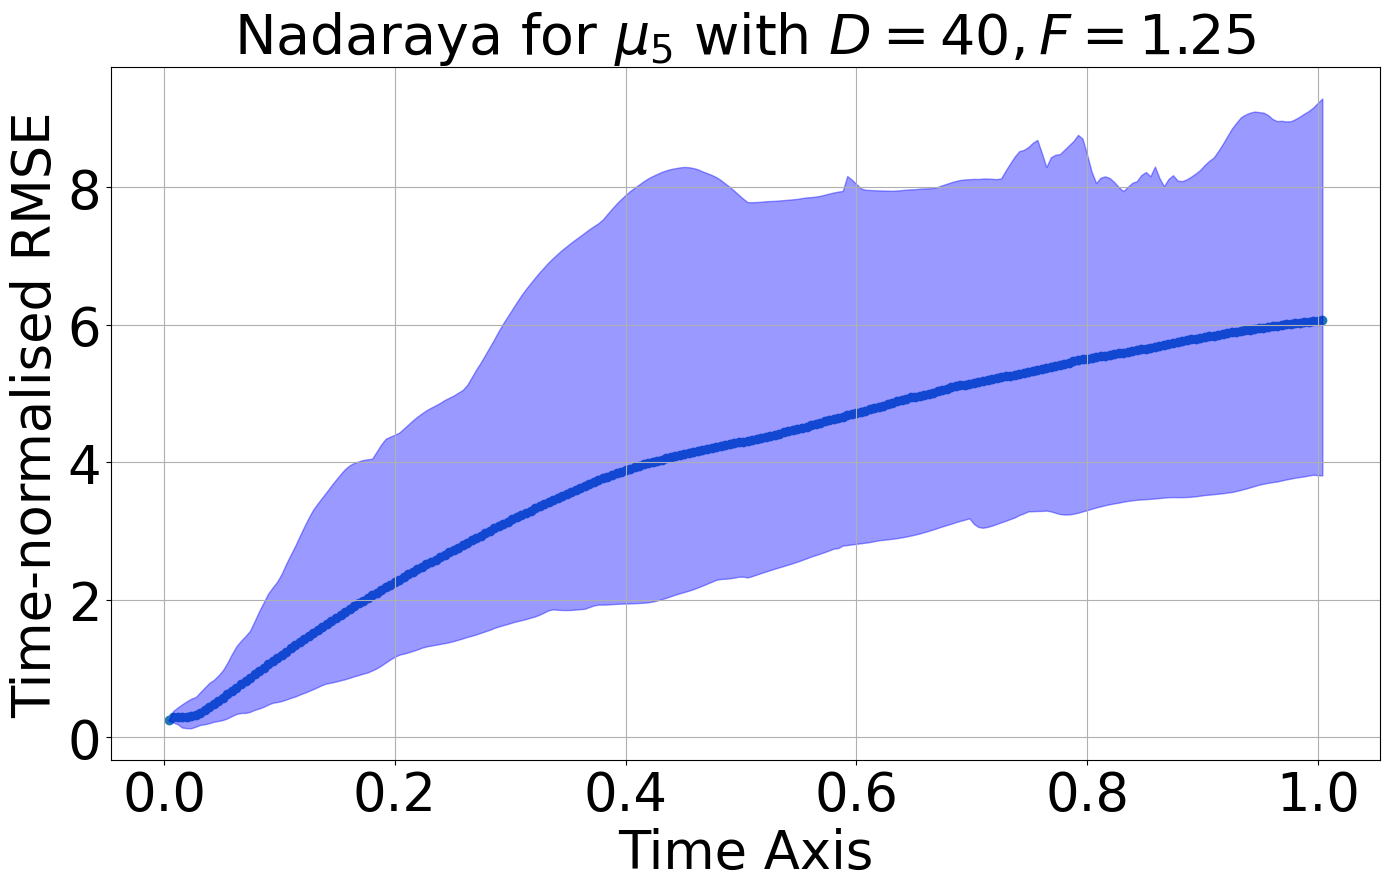

Final time cumulative MSE local-time error 6.067784109180492 with IQR ((3.8098512001976, 9.291385397216024))at bw 0.0293252 for 1.25FConst

5.9286746107520125 0.0387196 6.067784109180492


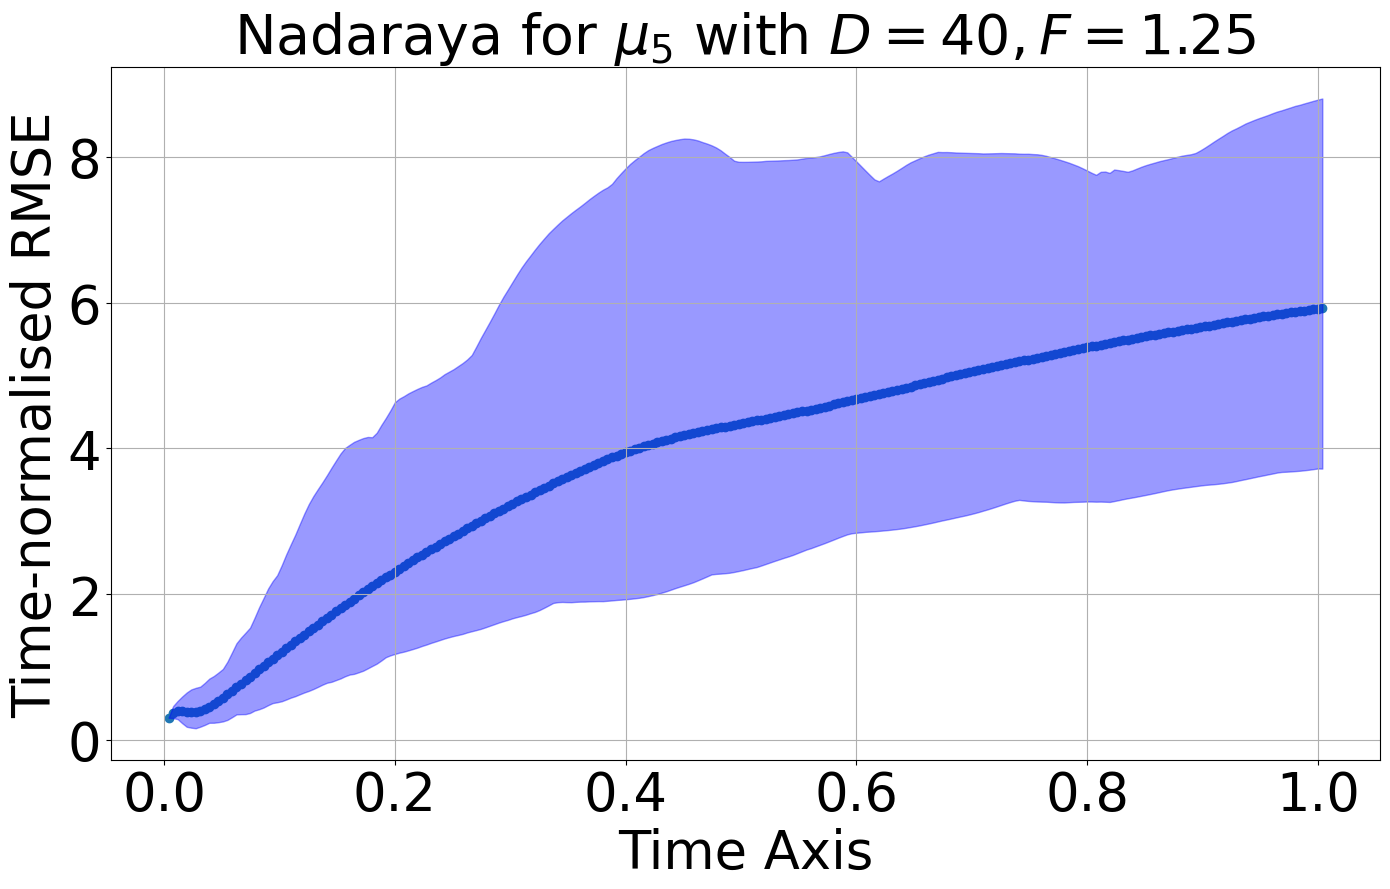

Final time cumulative MSE local-time error 5.9286746107520125 with IQR ((3.7233809821619523, 8.80194097943992))at bw 0.0387196 for 1.25FConst

5.909799125633247 0.0511235 5.9286746107520125


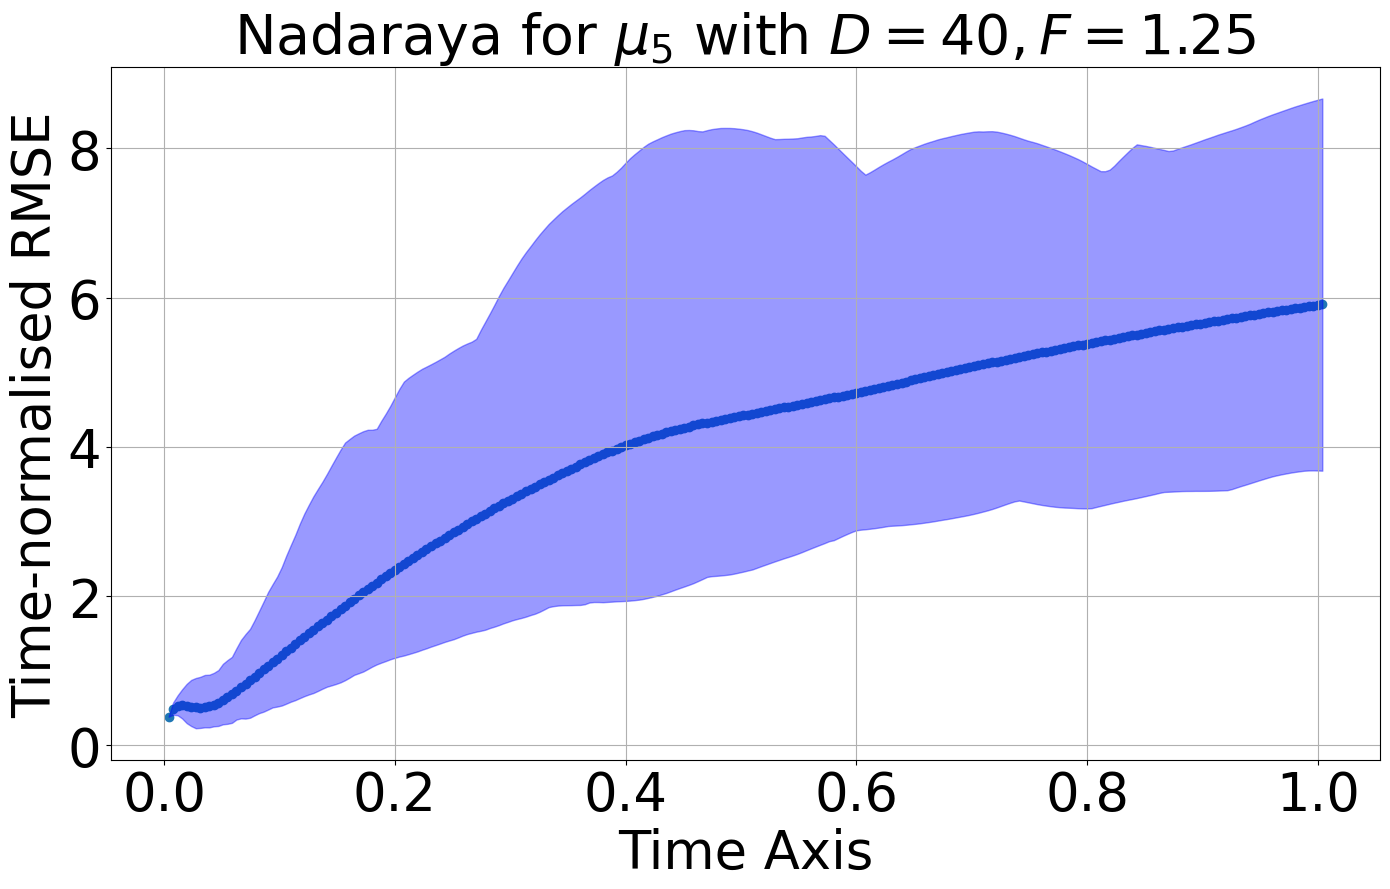

Final time cumulative MSE local-time error 5.909799125633247 with IQR ((3.6802032088222094, 8.666915699678176))at bw 0.0511235 for 1.25FConst

5.918906587655278 0.067501 5.909799125633247
5.964795118279218 0.0891251 5.909799125633247
6.57662363283142 0.1 5.909799125633247
6.013989785636555 0.1135011 5.909799125633247
6.0681167692606195 0.144544 5.909799125633247
6.124656133351302 0.1840772 5.909799125633247
6.182752194326243 0.2344229 5.909799125633247
6.244819712194838 0.2985383 5.909799125633247
6.319027181399588 0.3801894 5.909799125633247
6.429618811471158 0.4841724 5.909799125633247
6.616793646255342 0.616595 5.909799125633247
6.724845828276039 0.7852356 5.909799125633247


In [5]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Nadaraya for $\mu_5$ with $D={config.ts_dims}, F={'1.25' if config.forcing_const==1.25 else '0.75'}$",fontsize=40)
            ax.set_ylabel("Time-normalised RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                print(root_dir + f"DiffusionModelPresentationImages/")
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/40DLnzChaosGPU/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [6]:
print(np.logspace(-3.55, -0.05, 30))


[2.81838293e-04 3.72125692e-04 4.91336820e-04 6.48737444e-04
 8.56561639e-04 1.13096268e-03 1.49326859e-03 1.97163984e-03
 2.60325818e-03 3.43721657e-03 4.53833501e-03 5.99219871e-03
 7.91181023e-03 1.04463727e-02 1.37928868e-02 1.82114627e-02
 2.40455371e-02 3.17485677e-02 4.19192779e-02 5.53481932e-02
 7.30790854e-02 9.64901005e-02 1.27400876e-01 1.68213973e-01
 2.22101619e-01 2.93252268e-01 3.87196154e-01 5.11235131e-01
 6.75010215e-01 8.91250938e-01]


In [7]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

{'progress_name': 'idx',
 'span_units': 2.0,
 'wall_clock_h_total': 23.972774836950833,
 'wall_clock_per_unit_h': 11.986387418475415,
 'cpu_avg_pct': 1.5794444444444504,
 'cpu_peak_pct': 1.6,
 'ram_avg_gib': 380.32396238333354,
 'ram_peak_gib': 1928.274968,
 'gpu_util_avg_pct': None,
 'gpu_util_peak_pct': None,
 'gpu_mem_avg_gib': None,
 'gpu_mem_peak_gib': None}